In [9]:
import math
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

max_degree = 20 # 多项式最大阶数
n_train,n_test = 100,100
true_w = np.zeros(max_degree) # w相当于多项式前的系数
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

# 按照高斯分布，随机生成(n_train + n_test,1)的矩阵，期望默认是0，方差默认是1
features = np.random.normal(size = (n_train + n_test,1))
np.random.shuffle(features)
# 得到features^(0),features^(1),features^(2),...,features^(19)
poly_fearures = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_fearures[:,i] /= math.gamma(i+1)
labels = np.dot(poly_fearures,true_w)
# 加噪声
labels += np.random.normal(scale=0.1,size=labels.shape)

In [10]:
true_w,features,poly_fearures,labels = [
    torch.tensor(x,dtype=torch.float32)
    for x in [true_w,features,poly_fearures,labels]
]

features[:2],poly_fearures[:2,:],labels[:2]

(tensor([[ 0.7047],
         [-0.4741]]),
 tensor([[ 1.0000e+00,  7.0466e-01,  2.4827e-01,  5.8315e-02,  1.0273e-02,
           1.4478e-03,  1.7003e-04,  1.7116e-05,  1.5076e-06,  1.1804e-07,
           8.3177e-09,  5.3283e-10,  3.1288e-11,  1.6960e-12,  8.5362e-14,
           4.0101e-15,  1.7661e-16,  7.3204e-18,  2.8658e-19,  1.0628e-20],
         [ 1.0000e+00, -4.7409e-01,  1.1238e-01, -1.7760e-02,  2.1050e-03,
          -1.9959e-04,  1.5771e-05, -1.0681e-06,  6.3298e-08, -3.3344e-09,
           1.5808e-10, -6.8131e-12,  2.6917e-13, -9.8164e-15,  3.3242e-16,
          -1.0507e-17,  3.1132e-19, -8.6820e-21,  2.2867e-22, -5.7058e-24]]),
 tensor([5.4165, 4.0305]))

In [11]:
def evaluate_loss(net,data_iter,loss):
    '''评估给定数据集上模型的损失 net:网络，data_iter:数据，loss:损失'''
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [12]:
def train(train_features,test_features,train_labels,test_labels,num_epochs = 400):
    '''训练函数，给出训练集、测试集、训练集标签、测试集标签'''
    loss = nn.MSELoss()
    # train_features.shape[-1]表示最后一个元素
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape,1,bias = False))
    batch_size = min(10,train_labels.shape[0])

    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)

    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.979648   1.1949961 -3.393206   5.6326675]]


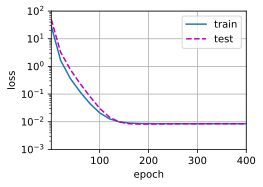

In [13]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_fearures[:n_train, :4], poly_fearures[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.071435 4.218436]]


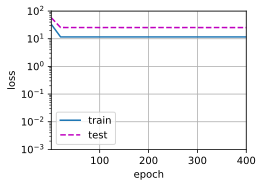

In [15]:
# 欠拟合
# 从多项式特征中选择前2个维度，即1和x
train(poly_fearures[:n_train, :2], poly_fearures[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.99221134e+00  1.29759419e+00 -3.43249226e+00  5.15167379e+00
  -2.60169711e-02  1.14148462e+00  4.53643471e-01  2.05610842e-02
   9.35025979e-03 -1.22172594e-01 -1.80175662e-01 -2.02963397e-01
  -2.15935409e-01  1.22249544e-01 -4.41224873e-02  6.06764369e-02
   1.62496552e-01 -9.54912568e-04  5.36904037e-02 -1.97214663e-01]]


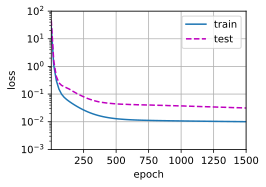

In [17]:
# 从多项式特征中选取所有维度
train(poly_fearures[:n_train, :], poly_fearures[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)